# Distribution of vegetation in a landscape of heterogeneous predation risk

In [1]:
# importing libraries

import numpy as np
from matplotlib import pyplot as plt
import math
from itertools import permutations as perm
import time
from matplotlib import animation as animate
import ray
from numba import njit

# initialising ray cluster

ray.init(dashboard_port=8265)

# Notebook parameters

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 30


## Defining initialisation functions

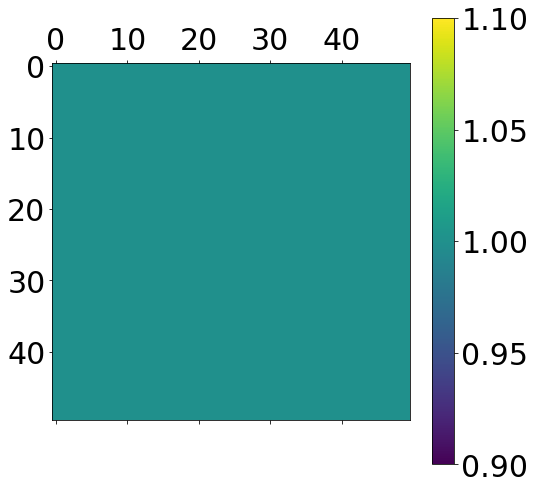

In [2]:
# Defining resource matrix

def veg(N):

    # Starting with resoource available everywhere

    V = np.full((N, N), 1)

    return V

# test plot


plt.matshow(veg(50))
plt.colorbar()


In [4]:
# Creating list of fish in the landscape

def fish_vec(n, N):

    # n = initial number of fish
    # N = size of the landscape

    # Iniital position at the center

    x = int(N/2)
    y = int(N/2)

    # Data for a single fish

    fish = np.array([(x, y), 0])  # [(position), starvation time]

    fish_pop = np.full((n, 2), fish)

    return fish_pop

# test


fish_vec(5, 50)


<ipython-input-4-542fcd90d27c>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  fish = np.array([(x, y), 0])  # [(position), starvation time]


array([[(25, 25), 0],
       [(25, 25), 0],
       [(25, 25), 0],
       [(25, 25), 0],
       [(25, 25), 0]], dtype=object)

<ipython-input-4-542fcd90d27c>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  fish = np.array([(x, y), 0])  # [(position), starvation time]


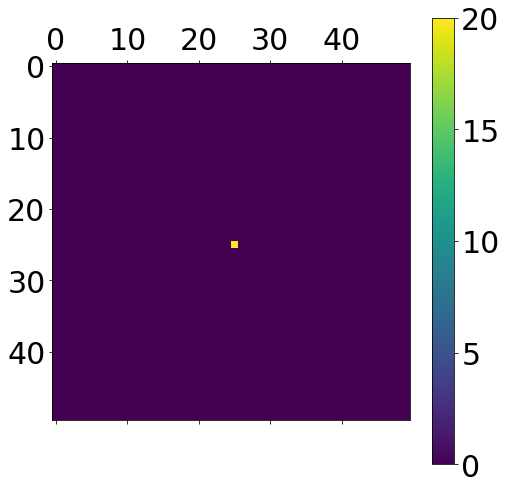

In [5]:
# summarising fish density in the landscape

def fish_mat(fish_pop, N):

    # creating an empty matrix for fish

    F = np.zeros((N, N))

    # Extracting fish positioins

    fish_pos = fish_pop[:, 0]

    # Summing number of fish in each cell

    for index, value in np.ndenumerate(F):

        for f in fish_pos:

            if index == f:

                F[index] += 1

    return F

# test


fish_pop = fish_vec(20, 50)

plt.matshow(fish_mat(fish_pop, 50))
plt.colorbar()


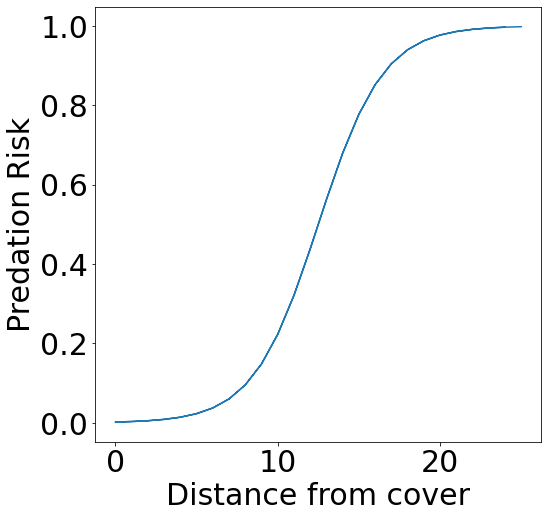

In [6]:
def risk_fun(dist, k=0.5, a=12.5):

    return (1/(1 + math.exp(-(dist-a)*k)))

    # return 1/(a + math.exp((25 - dist)*k))


N = 50
center = N/2

ix = N/2
iy = list(range(N))

d = [0]*N

r = [0]*N
for i in range(N):

    d[i] = ((center - ix)**2 + (center - iy[i])**2)**0.5
    r[i] = risk_fun(d[i])


plt.plot(d, r)
plt.xlabel('Distance from cover')
plt.ylabel('Predation Risk')
plt.savefig('fig4.png')

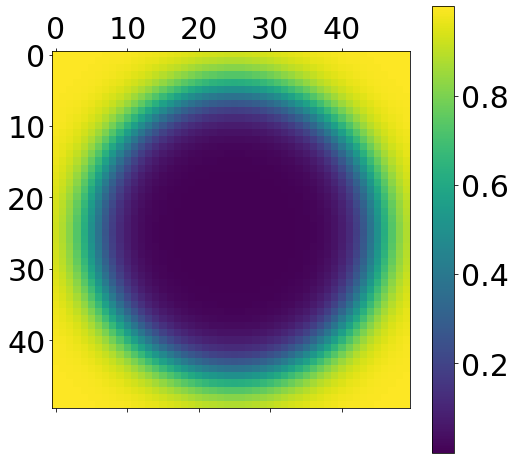

In [7]:
# Predation risk as a function of space

def risk(ix, iy, N=50, k=0.5, a=20):

    # Distance based change from the center

    center = N/2

    dist = ((center - ix)**2 + (center - iy)**2)**0.5

    alpha = (1/(1 + math.exp(-(dist-a)*k)))

    return alpha

# test


N = 50

x = list(range(N))
y = list(range(N))

index = 0

alpha = [0]*50*50

for ix in x:

    for iy in y:

        alpha[index] = risk(ix, iy, N)

        index += 1

alpha = np.array(alpha)

alpha = np.reshape(alpha, (50, 50))

plt.matshow(alpha)
plt.colorbar()


## Defining update functions

In [8]:
# Periodic boundaries

def pbound(pt, N):

    if pt >= N-1:

        return(abs(pt - N))

    elif pt < 0:

        return(abs(pt + N))

    else:

        return(pt)

# test


pbound(51, 50)


1

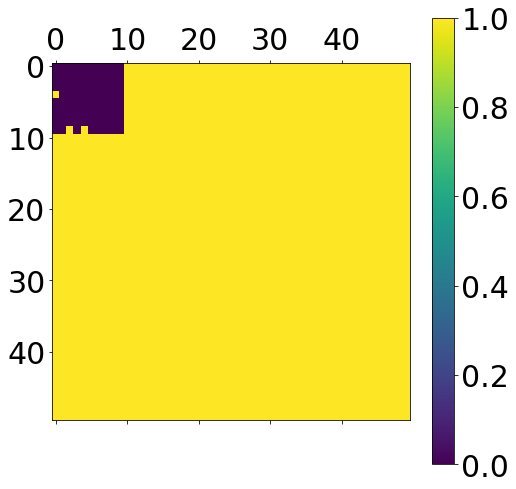

In [9]:
# spread and regeneration of vegetation

def veg_update(veg_mat, v=0.1):

    N = np.shape(veg_mat)  # getting shape of vegetation matrix

    for index, value in np.ndenumerate(veg_mat):

        if value == 0:

            adj = []  # empty list of adjascent cells

            # getting list of adjascent cells

            for dx in [-1, 0, 1]:

                for dy in [-1, 0, 1]:

                    x = index[0] + dx  # horizontal

                    y = index[1] + dy  # vertical

                    # Periodic boundaries

                    x = pbound(x, 50)
                    y = pbound(y, 50)

                    adj.append((x, y))

            # Spread of vegetation

            # Getting values from adjascent cells

            adj_veg = []

            for cell in adj:

                adj_veg.append(veg_mat[cell])

            # checking if neighbours are present

            if sum(adj_veg) > 0:

                # updating value

                veg_mat[index] = int(np.random.choice(
                    a=[0, 1], p=[1-v, v]))  # prob of reproducing

    return(veg_mat)

# Test


V = veg(50)

for dx in range(10):

    for dy in range(10):

        V[dx, dy] = 0

V = veg_update(V)

plt.matshow(V)
plt.colorbar()


<ipython-input-4-542fcd90d27c>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  fish = np.array([(x, y), 0])  # [(position), starvation time]


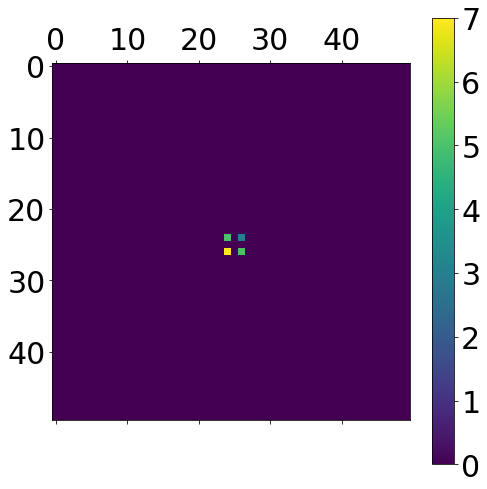

In [10]:
# updating fish positions

def fish_mov(fish_pop, N=50, k=0.5, a=20):

    index = 0

    for f in fish_pop:

        x = f[0][0]
        y = f[0][1]

        # Calculating risk

        xrisk = (risk(x+1, y, N, k=k, a=a) - risk(x-1, y, N, k=k, a=a))
        yrisk = (risk(x, y+1, N, k=k, a=a) - risk(x, y-1, N, k=k, a=a))

        # Calculating moves based on risk

        px = 0.5 - xrisk  # Risk of moving right vs left
        py = 0.5 - yrisk  # risk of moving up vs down

        # 2 - D risk - biased random walk

        dx = x + np.random.choice(a=[-1, 1], p=[(1-px), px])
        dy = y + np.random.choice(a=[-1, 1], p=[(1-py), py])

        # Periodic boundaries

        dx = pbound(dx, 50)

        dy = pbound(dy, 50)

        fish_pop[index][0] = (dx, dy)

        index += 1

    return fish_pop

# Test


fish_pop = fish_vec(20, 50)

fish_t1 = fish_mov(fish_pop)

plt.matshow(fish_mat(fish_t1, 50))
plt.colorbar()


In [11]:
# Fish reproduction

def fish_rep(fish_pop, r=0.01):

    for f in fish_pop:

        rep = np.random.choice(a=[0, 1], p=[1-r, r])  # P(reproduce)

        if rep == 1:

            f[1] = 0  # resetting starvation clock

            fish_pop = np.append(fish_pop, [f], axis=0)

    return fish_pop


# Test

fish_pop = fish_vec(20, 50)

print(len(fish_rep(fish_pop)))


20


<ipython-input-4-542fcd90d27c>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  fish = np.array([(x, y), 0])  # [(position), starvation time]


In [12]:
# Fish starvation

def fish_starve(fish_pop):

    index = 0

    idx = []

    for f in fish_pop:

        # At t_S = 10, fish dies

        if f[1] == 10:

            idx.append(index)

        else:

            # Starvation clock increases with each time step

            fish_pop[index, 1] = fish_pop[index, 1] + 1

        index += 1

    # Killing fish

    fish_pop = np.delete(fish_pop, idx, axis=0)

    return fish_pop

# Test


fish_pop = fish_vec(20, 50)

for t in range(12):

    fish_pop = fish_starve(fish_pop)

    print(len(fish_pop))


20
20
20
20
20
20
20
20
20
20
0
0


<ipython-input-4-542fcd90d27c>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  fish = np.array([(x, y), 0])  # [(position), starvation time]


<ipython-input-4-542fcd90d27c>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  fish = np.array([(x, y), 0])  # [(position), starvation time]


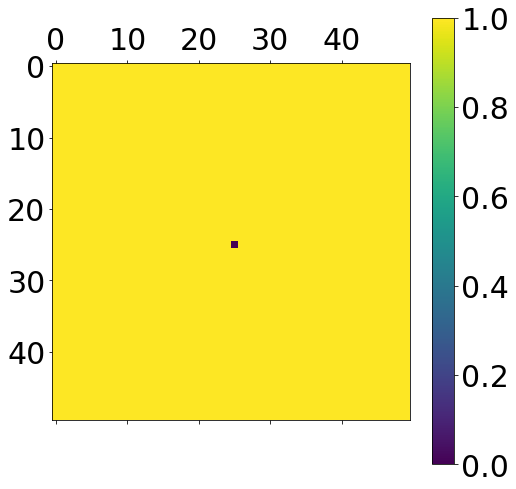

In [13]:
# Fish feeding

def fish_feed(fish_pop, veg_mat, q=5):

    index = 0

    for f in fish_pop:

        # Check if vegetation is present

        if veg_mat[f[0]] == 1:

            # Fish eats the vegetations

            # Veg disappears

            veg_mat[f[0]] = 0

            # Fish starvation clock starts over

            fish_pop[index, 1] = fish_pop[index, 1] - q

        index += 1

    return veg_mat, fish_pop

# Test


fish_pop = fish_vec(20, 50)

veg_mat = veg(50)

veg_mat, fish_pop = fish_feed(fish_pop, veg_mat)

plt.matshow(veg_mat)
plt.colorbar()


## Simulating 

In [14]:
%%time

# Simulation

T_max = 500


@ray.remote(num_returns=2)
def fish_sim(n=20, N=50, T_max=500, v=0.1, k=0.5, a=20, r=0.01, q=5):
    """
    n = initial number of fish
    N = size of the matrix
    T_max = maximum time to simulate
    v = vegetation growth rate
    k = slope of risk function
    a = half saturation distance for risk function
    r = fish reproduction rate
    q = feed gain for fish
    """

    # Initialising the landscape

    fish_pop = fish_vec(n, N)  # fish population
    veg_mat = veg(N)  # resource matrix

    # Results

    veg_res = np.zeros((N, N, T_max+2))  # resource
    veg_res[:, :, 0] = veg_mat  # initial conditions

    fish_res = np.zeros((N, N, T_max+2))  # fish
    fish_res[:, :, 0] = fish_mat(fish_pop, N)  # initial conditions

    for t in range(T_max):

        # Updating resource values

        veg_mat = veg_update(veg_mat, v=v)

        # Fish feeding

        veg_mat, fish_pop = fish_feed(fish_pop, veg_mat, q=q)

        # Fish starvation and death

        fish_pop = fish_starve(fish_pop)

        # Fish reproduce

        fish_pop = fish_rep(fish_pop, r=r)

        # Fish movement

        fish_pop = fish_mov(fish_pop, N=N, k=k, a=a)

        # Logging fish abundance

        fish_res[:, :, t+1] = fish_mat(fish_pop, N)

        # Logging resource

        veg_res[:, :, t+1] = veg_mat

    return fish_res, veg_res

# Test

fish_res, veg_res = ray.get(fish_sim.remote())


(pid=11621) <ipython-input-4-542fcd90d27c>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CPU times: user 963 ms, sys: 196 ms, total: 1.16 s
Wall time: 40.8 s


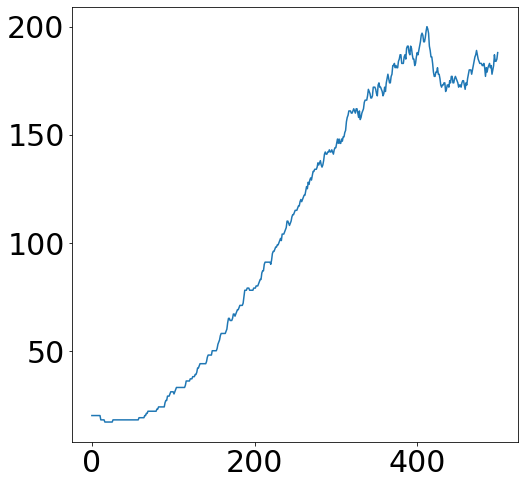

In [15]:
# Extracting abundance from matrix

@njit(parallel = True)
def abn(mat, T_max=500):
    """ mat is 2-D simulation result across time (3-D array)"""

    res = [0]*T_max

    for t in range(T_max):

        res[t] = np.sum(mat[:, :, t])

    return res


# test

fish_abn = abn(fish_res)

plt.plot(range(500), fish_abn)


Text(0, 0.5, 'Variance')

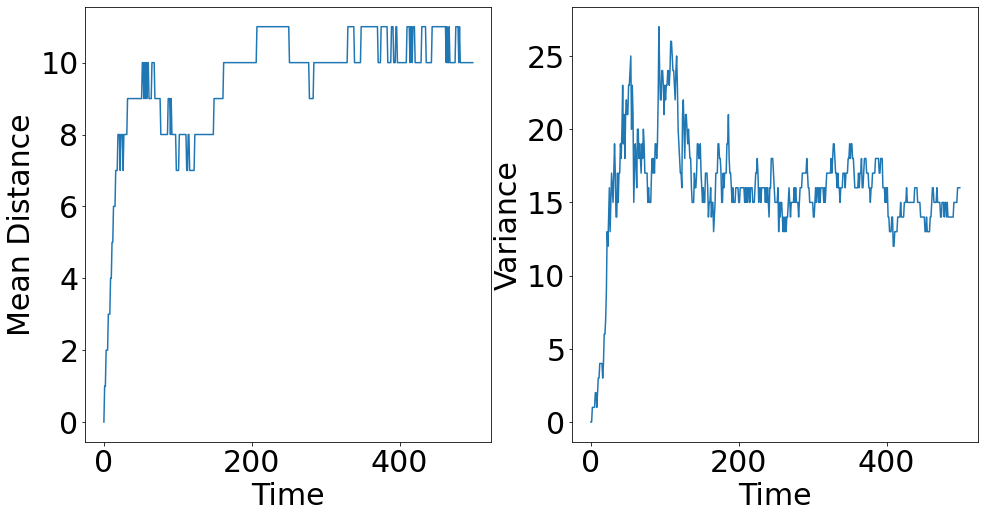

In [16]:
@njit()
def movement(mat, N = 50, T_max = 500):

    c = N/2 #center

    mean_dist = [0]*(T_max)

    var_dist = [0]*(T_max)

    for t in range(T_max):

        abn = np.sum(mat[:,:,t])

        dist = np.zeros(int(abn))

        ind = 0

        for index, value in np.ndenumerate(mat[:,:,t]):

            if value > 0: # checking for presence of fish 

                # distance of each element from center

                for _ in range(int(value)):

                    dist[ind] = ((c - index[0])**2 + (c - index[1])**2)**0.5

                    ind += 1

            mean_dist[t] = np.mean(dist)
            var_dist[t] = np.var(dist)
    
    return mean_dist, var_dist

mean_dist, var_dist = movement(fish_res)

fig, axis = plt.subplots(1,2, figsize = (16, 8))

axis[0].plot(range(T_max), mean_dist)
axis[0].set_xlabel('Time')
axis[0].set_ylabel('Mean Distance')
axis[1].plot(range(T_max), var_dist)
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Variance')    

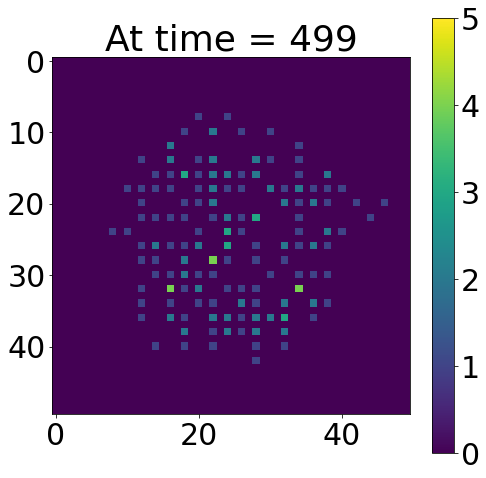

In [17]:
# Animating fish movement in the landscape

def lilly(slice):

    plt.clf()
    plt.imshow(fish_res[:, :, slice])
    plt.colorbar()
    plt.title(f"At time = {slice}")
    plt.clim(0, 5)


anim = animate.FuncAnimation(
    plt.figure(), lilly, range(T_max), interval=100)

anim.save("sim1.gif")


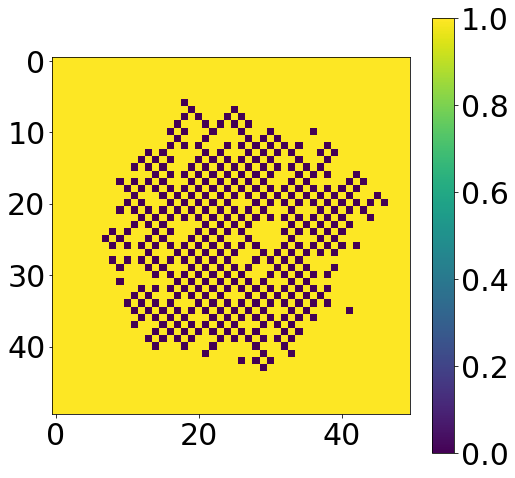

In [18]:
# Final vegetation distribution

plt.imshow(veg_res[:, :, T_max])
plt.colorbar()


## Experiment

Testing stability as a function of input rate and reproduction rate in the absence of predation

In [19]:
# varying distance and exponent of risk function

# Defining simulation parameters

T_max = 1000  # time for the simulation
N = 50  # length of side for N x N matrix
n = 20  # initial number of fish

v = list(np.arange(0.01, 0.1, 0.01))
r = list(np.arange(0.01, 0.1, 0.01))

iter = 1

# Results matrices

sim_fish_0 = [0]*len(r)*len(v)*iter  # np.zeros((len(k), len(a)))
sim_veg_0 = [0]*len(r)*len(v)*iter  # np.zeros((len(k), len(a)))

x = 0  # ray sync

for i in range(len(v)):

    for j in range(len(r)):

        for rep in range(iter):

            sim_fish_0[x], sim_veg_0[x] = fish_sim.remote(N=N, T_max=T_max, a=100, v = v[i], r = r[j])

            x += 1

# Retrieving ray futures

fish_res_0 = ray.get(sim_fish_0)
veg_res_0 = ray.get(sim_veg_0)


(pid=11563) <ipython-input-4-542fcd90d27c>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
(pid=11568) <ipython-input-4-542fcd90d27c>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
(pid=11561) <ipython-input-4-542fcd90d27c>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
(pid=11571) <ipython-input-4-542fcd90d27c>:15: VisibleDeprecatio

In [35]:
# Extracting metrics
v = list(np.arange(0.01, 0.1, 0.01))
r = list(np.arange(0.01, 0.1, 0.01))

fish_abn_0 = np.zeros((len(r), len(v), iter, T_max))
veg_abn_0 = np.zeros((len(r), len(v), iter, T_max))

x = 0

for i in range(len(v)):

    for j in range(len(r)):

        for z in range(iter):
            
            # abundance

            fish_abn_0[i, j, z] = abn(fish_res_0[x], T_max) #fish

            veg_abn_0[i, j, z] = abn(veg_res_0[x], T_max) #resource

            
            x += 1

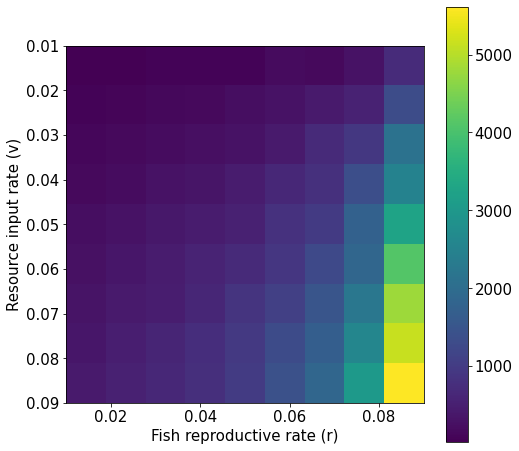

In [48]:
plt.imshow(fish_abn_0[:,:,:,T_max-1], extent=[0.01, 0.09, 0.09, 0.01])
plt.xlabel('Fish reproductive rate (r)')
plt.ylabel('Resource input rate (v)')
plt.colorbar()

plt.savefig('fig6_1.png')

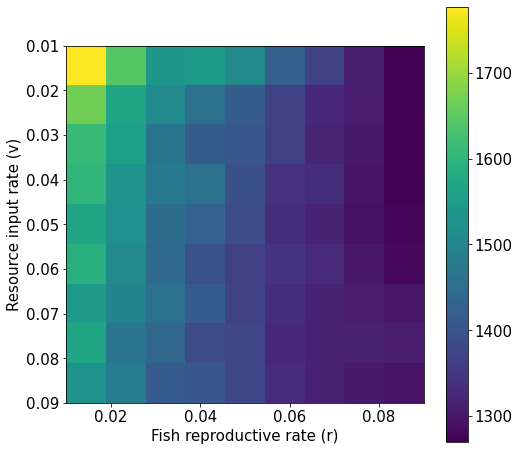

In [49]:
plt.imshow(veg_abn_0[:,:,:,T_max-1], extent=[0.01, 0.09, 0.09, 0.01])
plt.xlabel('Fish reproductive rate (r)')
plt.ylabel('Resource input rate (v)')
plt.colorbar()

plt.savefig('fig6_2.png')

## Experiment 1

Varying risk gradient, vegetations input and fish reproductive rate

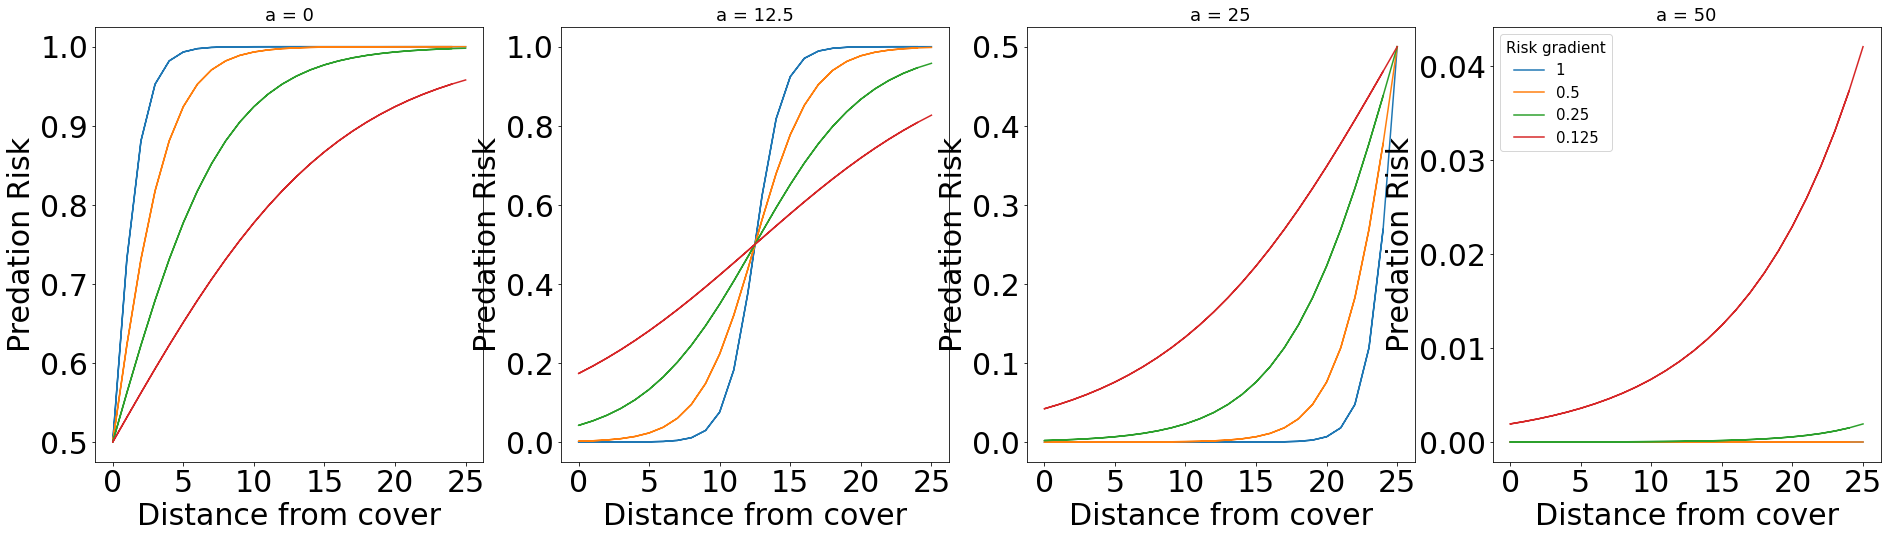

In [22]:
# varying risk

N = 50
center = N/2

ix = N/2
iy = list(range(N))

d = [0]*N

r = [0]*N

k = [1, 0.5, 0.25, 0.125]  # exponent

a = [0, 12.5, 25, 50]  # half saturation distance

fig, axis = plt.subplots(1, 4, figsize=(32, 8))

plt.rcParams['font.size'] = '15'

m = 0; n = 0

for x in range(len(k)):

    for j in range(len(a)):

        for i in range(N):

            d[i] = ((center - ix)**2 + (center - iy[i])**2)**0.5

            r[i] = risk_fun(d[i], a=a[j], k=k[x])

        axis[j].plot(d, r, label = k[x])
        axis[j].set_ylabel('Predation Risk')
        axis[j].set_xlabel('Distance from cover')
        axis[j].set_title('a = %a' % (a[j]))

plt.legend(title = 'Risk gradient')
plt.savefig('fig4.png')

In [51]:
# varying distance and exponent of risk function

# Defining simulation parameters

T_max = 1000  # time for the simulation
N = 50  # length of side for N x N matrix
n = 20  # initial number of fish

k = [1, 0.5, 0.25, 0.125]  # exponent

a = list(range(0, N, 5))  # half saturation distance

iter = 10

# Results matrices

sim_fish = [0]*len(k)*len(a)*iter  # np.zeros((len(k), len(a)))
sim_veg = [0]*len(k)*len(a)*iter  # np.zeros((len(k), len(a)))

x = 0  # ray sync

for i in range(len(k)):

    for j in range(len(a)):

        for rep in range(iter):

            sim_fish[x], sim_veg[x] = fish_sim.remote(N=N, T_max=T_max, k=k[i], a=a[j])

            x += 1

# Retrieving ray futures

fish_res = ray.get(sim_fish)
veg_res = ray.get(sim_veg)


In [ ]:
# Extracting metrics

fish_abn = np.zeros((len(k), len(a), iter, T_max))
veg_abn = np.zeros((len(k), len(a), iter, T_max))
mean_dist = np.zeros((len(k), len(a), iter, T_max))
var_dist = np.zeros((len(k), len(a), iter, T_max))

x = 0

for i in range(len(k)):

    for j in range(len(a)):

        for r in range(iter):
            
            # abundance

            fish_abn[i, j, r] = abn(fish_res[x], T_max) #fish

            veg_abn[i, j, r] = abn(veg_res[x], T_max) #resource

            # movement

            mean_dist[i, j, r], var_dist[i, j, r] = movement(fish_res[x], T_max = T_max)

            x += 1



In [ ]:
fig, axis = plt.subplots(4, 4, figsize=(16, 16))

plt.rcParams['font.size'] = '10'

a_sub = list(range(0, 20, 5))

for i in range(len(k)):

    for j in range(len(a_sub)):

        axis[i, j].plot(range(T_max), veg_abn[i, j, iter-1, :])
        axis[i, j].set_title('a = %a; k = %a' % (a_sub[j], k[i]))
        axis[i, j].set_ylim([np.min(veg_abn)-100, np.max(veg_abn)+100])


In [ ]:
fig, axis = plt.subplots(4, 4, figsize=(16, 16))

plt.rcParams['font.size'] = '10'

a_sub = list(range(0, 20, 5))

for i in range(len(k)):

    for j in range(len(a_sub)):

        axis[i, j].plot(range(T_max), fish_abn[i, j, iter-1, :])
        axis[i, j].set_title('a = %a; k = %a' % (a_sub[j], k[i]))
        axis[i, j].set_ylim([np.min(fish_abn)-10, np.max(fish_abn)+10])


In [ ]:
k = [1, 0.5, 0.25, 0.125]  # exponent

a = list(range(0, 100, 5))  # half saturation distance

plt.rcParams['font.size'] = '15'

veg_eq = np.zeros((len(k), len(a)))
veg_var = np.zeros((len(k), len(a)))

fig, axis = plt.subplots(1, 2, figsize = (16,8))

for i in range(len(k)):

    for j in range(len(a)):

        veg_eq[i, j] = np.mean(veg_abn[i, j, :, (T_max-100):(T_max-1)])
        veg_var[i, j] = np.var(veg_abn[i, j, :, (T_max-100):(T_max-1)])

    axis[0].scatter(a, veg_eq[i, :], label=k[i])
    axis[0].plot(a, veg_eq[i, :])

    axis[1].scatter(a, veg_var[i, :], label=k[i])
    axis[1].plot(a, veg_var[i, :])



axis[0].set_xlabel('Risk intensity (a)')
axis[0].set_ylabel('Vegetation abundance')
#plt.errorbar(a, veg_eq[i,:], label = k[i], yerr = veg_var[i,:], fmt='o')
axis[1].set_xlabel('Risk intensity (a)')
axis[1].set_ylabel('Variance')
axis[1].legend(title = 'Risk Gradient (k)')

plt.savefig('fig1.png')


In [ ]:
k = [1, 0.5, 0.25, 0.125]  # exponent

a = list(range(0, 100, 5))  # half saturation distance

plt.rcParams['font.size'] = '15'

mov_eq = np.zeros((len(k), len(a)))
mov_var = np.zeros((len(k), len(a)))

fig, axis = plt.subplots(1, 2, figsize = (16,8))

for i in range(len(k)):

    for j in range(len(a)):

        mov_eq[i, j] = np.mean(mean_dist[i, j, :, (T_max-100):(T_max-1)])
        mov_var[i, j] = np.mean(var_dist[i, j, :, (T_max-100):(T_max-1)])

    axis[0].scatter(a, mov_eq[i, :], label=k[i])
    axis[0].plot(a, mov_eq[i, :])

    axis[1].scatter(a, mov_var[i, :], label=k[i])
    axis[1].plot(a, mov_var[i, :])



axis[0].set_xlabel('Risk intensity (a)')
axis[0].set_ylabel('Mean distance from cover')
#plt.errorbar(a, veg_eq[i,:], label = k[i], yerr = veg_var[i,:], fmt='o')
axis[1].set_xlabel('Risk intensity (a)')
axis[1].set_ylabel('Variance')
axis[1].legend(title = 'Risk Gradient (k)')

plt.savefig('fig5.png')

In [ ]:
fish_eq = np.zeros((len(k), len(a)))
fish_var = np.zeros((len(k), len(a)))

for i in range(len(k)):

    for j in range(len(a)):

        fish_eq[i, j] = np.mean(fish_abn[i, j, :, (T_max-100):(T_max-1)])
        fish_var[i, j] = np.var(fish_abn[i, j, :, (T_max-100):(T_max-1)])

    plt.scatter(a, fish_eq[i, :], label=k[i])
    plt.plot(a, fish_eq[i, :])
    plt.legend()


## Experiment 2

Varying input rate with and without predation pressure

In [ ]:
# varying distance and exponent of risk function

# Defining simulation parameters

T_max = 1000  # time for the simulation
N = 50  # length of side for N x N matrix
n = 20  # initial number of fish

k = [1, 0.5, 0.25, 0.125]  # exponent

a = 20 # half saturation distance

v = np.arange(0.1, 1, 0.1) # vegetation input rate

iter = 10

# Results matrices

sim_fish_2 = [0]*len(k)*len(v)*iter  # np.zeros((len(k), len(a)))
sim_veg_2 = [0]*len(k)*len(v)*iter  # np.zeros((len(k), len(a)))

x = 0  # ray sync

for i in range(len(k)):

    for j in range(len(v)):

        for rep in range(iter):

            sim_fish_2[x], sim_veg_2[x] = fish_sim.remote(N=N, T_max=T_max, k=k[i], v=v[j], a = a)

            x += 1

# Retrieving ray futures

fish_res_2 = ray.get(sim_fish_2)
veg_res_2 = ray.get(sim_veg_2)


In [ ]:
# Extracting metrics

fish_abn_2 = np.zeros((len(k), len(a), iter, T_max))
veg_abn_2 = np.zeros((len(k), len(a), iter, T_max))
mean_dist_2 = np.zeros((len(k), len(a), iter, T_max))
var_dist_2 = np.zeros((len(k), len(a), iter, T_max))

x = 0

for i in range(len(k)):

    for j in range(len(a)):

        for r in range(iter):
            
            # abundance

            fish_abn_2[i, j, r] = abn(fish_res_2[x], T_max) #fish

            veg_abn_2[i, j, r] = abn(veg_res_2[x], T_max) #resource

            # movement

            mean_dist_2[i, j, r], var_dist_2[i, j, r] = movement(fish_res_2[x], T_max = T_max)

            x += 1



In [ ]:
k = [1, 0.5, 0.25, 0.125]  # exponent

v = np.arange(0.1, 1, 0.1) # vegetation input rate

plt.rcParams['font.size'] = '15'

fig, axis = plt.subplots(1,2, figsize = (16,8))
veg_eq_2 = np.zeros((len(k), len(v)))
veg_var_2 = np.zeros((len(k), len(v)))

for i in range(len(k)):

    for j in range(len(v)):

        veg_eq_2[i, j] = np.mean(veg_abn_2[i, j, :, (T_max-100):(T_max-1)])
        veg_var_2[i, j] = np.var(veg_abn_2[i, j, :, (T_max-100):(T_max-1)])

    axis[0].scatter(v, veg_eq_2[i, :], label=k[i])
    axis[0].plot(v, veg_eq_2[i, :])

    axis[1].scatter(v, veg_var_2[i, :], label=k[i])
    axis[1].plot(v, veg_var_2[i, :])

axis[0].set_xlabel('Vegetation input rate (v)')
axis[0].set_ylabel('Vegetation abundance')
#plt.errorbar(a, veg_eq[i,:], label = k[i], yerr = veg_var[i,:], fmt='o')
axis[1].set_xlabel('Vegetation input rate (v)')
axis[1].set_ylabel('Variance')
axis[1].legend(title = 'Risk Gradient (k)')

plt.savefig('fig2.png')


In [ ]:
fish_eq_2 = np.zeros((len(k), len(v)))
fish_var_2 = np.zeros((len(k), len(v)))

for i in range(len(k)):

    for j in range(len(v)):

        fish_eq_2[i, j] = np.mean(fish_abn_2[i, j, :, (T_max-100):(T_max-1)])
        fish_var_2[i, j] = np.var(fish_abn_2[i, j, :, (T_max-100):(T_max-1)])

    plt.scatter(v, fish_eq_2[i, :], label=k[i])
    plt.plot(v, fish_eq_2[i, :])
    plt.legend()


## Experiment 3

Varying predation gradient

In [ ]:
# varying distance and exponent of risk function

# Defining simulation parameters

T_max = 1000  # time for the simulation
N = 50  # length of side for N x N matrix
n = 20  # initial number of fish

k = 0.5  # exponent

a = list(range(0, 100, 20)) # half saturation distance

v = np.arange(0.1, 1, 0.1) # vegetation input rate

iter = 10

# Results matrices

sim_fish_3 = [0]*len(k)*len(a)*iter  # np.zeros((len(k), len(a)))
sim_veg_3 = [0]*len(k)*len(a)*iter  # np.zeros((len(k), len(a)))

x = 0  # ray sync

for i in range(len(a)):

    for j in range(len(v)):

        for rep in range(iter):

            sim_fish_3[x], sim_veg_3[x] = fish_sim.remote(N=N, T_max=T_max, k=k, a=a[i], v = v[j])

            x += 1

# Retrieving ray futures

fish_res_3 = ray.get(sim_fish_3)
veg_res_3 = ray.get(sim_veg_3)


In [ ]:
# Extracting metrics

fish_abn_3 = np.zeros((len(k), len(a), iter, T_max))
veg_abn_3 = np.zeros((len(k), len(a), iter, T_max))
mean_dist_3 = np.zeros((len(k), len(a), iter, T_max))
var_dist_3 = np.zeros((len(k), len(a), iter, T_max))

x = 0

for i in range(len(k)):

    for j in range(len(a)):

        for r in range(iter):
            
            # abundance

            fish_abn_3[i, j, r] = abn(fish_res_3[x], T_max) #fish

            veg_abn_3[i, j, r] = abn(veg_res_3[x], T_max) #resource

            # movement

            mean_dist_3[i, j, r], var_dist_3[i, j, r] = movement(fish_res_3[x], T_max = T_max)

            x += 1



In [ ]:
a = list(range(0, 100, 20)) # half saturation distance

v = np.arange(0.1, 1, 0.1) # vegetation input rate

plt.rcParams['font.size'] = '15'

fig, axis = plt.subplots(1,2, figsize = (16,8))

veg_eq_3 = np.zeros((len(a), len(v)))
veg_var_3 = np.zeros((len(a), len(v)))

for i in range(len(a)):

    for j in range(len(v)):

        veg_eq_3[i, j] = np.mean(veg_abn_3[i, j, :, (T_max-100):(T_max-1)])
        veg_var_3[i, j] = np.var(veg_abn_3[i, j, :, (T_max-100):(T_max-1)])

    axis[0].scatter(v, veg_eq_3[i, :], label=a[i])
    axis[0].plot(v, veg_eq_3[i, :])

    axis[1].scatter(v, veg_var_3[i, :], label=a[i])
    axis[1].plot(v, veg_var_3[i, :])

axis[0].set_xlabel('Vegetation input rate (v)')
axis[0].set_ylabel('Vegetation abundance')
#plt.errorbar(a, veg_eq[i,:], label = k[i], yerr = veg_var[i,:], fmt='o')
axis[1].set_xlabel('Vegetation input rate (v)')
axis[1].set_ylabel('Variance')
axis[1].legend(title = 'Risk intensity (a)')

plt.savefig('fig3.png')

In [ ]:
fish_eq_3 = np.zeros((len(a), len(v)))
fish_var_3 = np.zeros((len(a), len(v)))

for i in range(len(a)):

    for j in range(len(v)):

        fish_eq_3[i, j] = np.mean(fish_abn_3[i, j, :, (T_max-100):(T_max-1)])
        fish_var_3[i, j] = np.var(fish_abn_3[i, j, :, (T_max-100):(T_max-1)])

    plt.scatter(v, fish_eq_3[i, :], label=a[i])
    plt.plot(v, fish_eq_3[i, :])
    plt.legend()
